In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import heapq

In [2]:
class Ball:
    def __init__(self, center, radius):
        self.coordinates = center
        self.radius = radius

    def to_bound_balls(self, ball1, ball2):
        self.coordinates = [(ball1.coordinates[i] + ball2.coordinates[i]) / 2 for i in range(len(ball1.coordinates))]
        pom = max(ball1.radius, ball2.radius)
        self.radius = ((self.coordinates[0] - ball1.coordinates[0])**2 + (self.coordinates[1] - ball1.coordinates[1])**2)**0.5 + pom + 0.1

    def V(self):
        return np.pi * self.radius**2

    def get_c(self):
        return self.coordinates
        
    def get_r(self):
        return self.radius

In [3]:
class BallTreeNode:
    def __init__(self, leaf):
        self.left = None
        self.right = None
        self.parent = None
        self.ball = None
        self.leaf = leaf

    def set_left(self, node):
        self.left = node

    def set_right(self, node):
        self.right = node

    def set_parent(self, node):
        self.parent = node

    def set_ball(self, ball):
        self.ball = ball

    def forget(self):
        self.left = self.right = self.parent = None
        self.ball = None

In [4]:
class FringeElement:
    def __init__(self, node, aexp=0, ndvol=0):
        self.node = node   # Čvor u fringe
        self.aexp = aexp   # Proširenje nadređenog čvora (ancestor expansion)
        self.ndvol = ndvol # Zapremina trenutnog čvora

    def __lt__(self, other):
        # Potrebno za heapq da bi rangirao elemente prema proširenju
        return self.aexp < other.aexp

In [5]:
class BallTree:
    def __init__(self):
        self.root = None

    def best_sibling(self, nl):
        if self.root is None:
            return None  # Prazno stablo

        tb = Ball([0,0],0)  # Ovo će biti globalni test ball (zapremina)
        tb.to_bound_balls(self.root.ball, nl.ball)
        bcost = tb.V()  # Inicijalni najbolji trošak

        frng = []
        heapq.heapify(frng)

        # Ako koren nije list, dodaj ga u prioritetni red
        if not self.root.leaf:
            tf = FringeElement(self.root, aexp=0, ndvol=bcost)
            heapq.heappush(frng, tf)

        best_node = self.root

        # Pretraga
        done = False
        while frng and not done:
            tf = heapq.heappop(frng)  # Uzmi najbolji kandidat

            if tf.aexp >= bcost:
                done = True  # Zaustavi pretragu - nema boljeg
            else:
                
                e = tf.aexp + tf.ndvol - tf.node.ball.V()

                # Levi čvor
                tb.to_bound_balls(tf.node.left.ball, nl.ball)
                v = tb.V()
                if v + e < bcost:
                    bcost = v + e
                    best_node = tf.node.left

                if not tf.node.left.leaf:
                    tf2 = FringeElement(tf.node.left, aexp=e, ndvol=v)
                    heapq.heappush(frng, tf2)

                # Desni čvor
                tb.to_bound_balls(tf.node.right.ball, nl.ball)
                v = tb.V()
                if v + e < bcost:
                    bcost = v + e
                    best_node = tf.node.right

                if not tf.node.right.leaf:
                    tf2 = FringeElement(tf.node.right, aexp=e, ndvol=v)
                    heapq.heappush(frng, tf2)

        # Nakon pretrage vraćamo najbolji čvor za umetanje
        return best_node
        
    def ins_at_node(self, nl, n):
        """
        Umetanje nl kao brata čvora n.
        """
        # Ako nema roditelja, nl postaje korenski čvor
        
        nl.set_parent(None)

        # Ako je stablo prazno, postavi nl kao koren
        if self.root is None:
            self.root = nl
        else:
            # Kreiraj novog roditelja za čvor n i nl
            npar = BallTreeNode(False)
            npar.set_parent(n.parent)

            # Ako je n na vrhu stabla (nema roditelja), npar postaje novi koren
            if n.parent is None:
                self.root = npar
            elif n.parent.left == n:
                n.parent.set_left(npar)
            else:
                n.parent.set_right(npar)

            # Poveži čvorove npar, n, i nl
        
        
            npar.set_left(n)
            npar.set_right(nl)
            nl.set_parent(npar)
            n.set_parent(npar)

            # Kreiraj novu loptu koja obuhvata nl i n
            nbl = Ball([0,0],0)  # Inicijalno 0, kasnije će se računati stvarni volumen
            nbl.to_bound_balls(nl.ball, n.ball)
            npar.set_ball(nbl)

            # Ažuriraj roditeljske čvorove (volumene, itd.)
            self.repair_parents(npar)

    def repair_parents(self, node):
        current = node
        while current.parent:
            # Računaj novu loptu koja obuhvata levog i desnog potomka
            current_bl = Ball([0,0],0)
            current_bl.to_bound_balls(current.left.ball, current.right.ball)
            current.set_ball(current_bl)
            current = current.parent


    def remove(self, n):
        """
        Uklanja list čvor n iz stabla. Ako je poslednji čvor u stablu, stablo postaje prazno.
        """
        # Ako je n prazan (Void), ne radi ništa
        if n is None:
            return
        # Ako nema roditelja, n je poslednji čvor, pa zaboravi stablo
        elif n.parent is None:
            self.root = None
        else:
            np = n.parent

            # Pronađi sibling (brata) čvora n
            if n == np.left:
                ns = np.right
            else:
                ns = np.left

            # Poveži sibling ns sa roditeljem čvora np
            ns.set_parent(np.parent)

            # Ako je np roditelj koren, ns postaje novi koren
            if np.parent is None:
                self.root = ns
            elif np.parent.left == np:
                np.parent.set_left(ns)
            else:
                np.parent.set_right(ns)

            # Zaboravi np i ažuriraj n
            np.forget()
            n.set_parent(None)

            # Ažuriraj nadređene čvorove (lopte) dok ne dođemo do vrha stabla
            current = np.parent
            while current:
                current.ball.to_bound_balls(current.left.ball, current.right.ball)
                current = current.parent

            # Osiguraj da je n bez roditelja (postavi ga na None)
            n.set_parent(None)

In [6]:
balls = [
    Ball([-1, 2], 0.8), #A
    Ball([2.1, 4], 0.6), #C
    Ball([2.03,9], 0.6),  #B
    Ball([6, 8], 0.5),  #E
    Ball([1, 6], 2), #D
    Ball([7,3], 0.75),#F
    Ball([8, 4.5], 1)
]

In [7]:
import random

In [8]:
np.random.seed(42)

In [9]:
i = np.arange(len(balls))

In [10]:
i_new = np.random.permutation(i)

In [11]:
i_new

array([0, 1, 5, 2, 4, 3, 6])

In [12]:
ball_new = []
for j in i_new:
    ball_new.append(balls[j])

In [13]:
nodes = []
for b in ball_new:
    node = BallTreeNode(True)
    node.set_ball(b)
    nodes.append(node)

In [14]:
tree = BallTree()

In [15]:
for node in nodes:
  best_sibiling = tree.best_sibling(node)
  print(node.ball.coordinates)
  if not best_sibiling == None:
      print(best_sibiling.ball.coordinates)
  print("------------------")
  tree.ins_at_node(node, best_sibiling)

[-1, 2]
------------------
[2.1, 4]
[-1, 2]
------------------
[7, 3]
[0.55, 3.0]
------------------
[2.03, 9]
[7, 3]
------------------
[1, 6]
[0.55, 3.0]
------------------
[6, 8]
[2.03, 9]
------------------
[8, 4.5]
[7, 3]
------------------


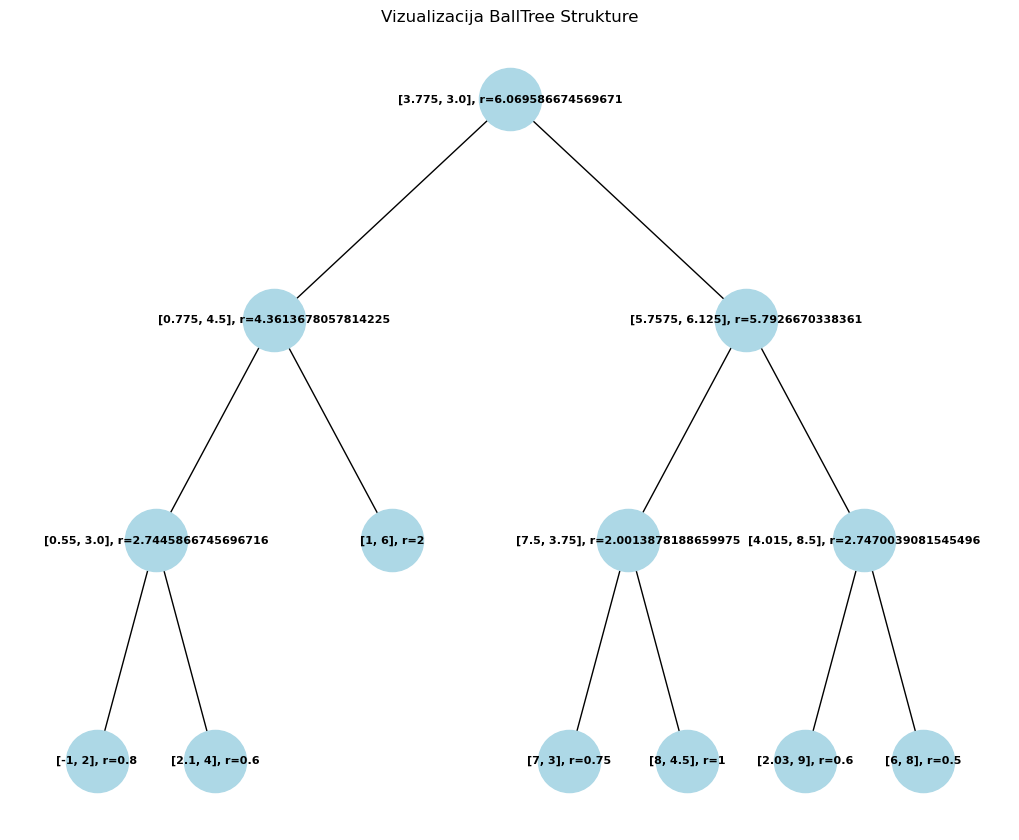

In [16]:
import networkx as nx

def plot_ball_tree(node, pos=None, level=0, x=0, dx=1.0, graph=None, labels=None):
    """ Pomoćna funkcija za rekursivno crtanje BallTree strukture. """
    if pos is None:
        pos = {}
    if graph is None:
        graph = nx.Graph()
    if labels is None:
        labels = {}

    pos[node] = (x, -level)
    labels[node] = f"{node.ball.coordinates}, r={node.ball.radius}"

    # Ako ima levog deteta, dodaj u graf i rekurzivno pozovi za levo dete
    if node.left is not None:
        graph.add_edge(node, node.left)
        plot_ball_tree(node.left, pos=pos, level=level + 1, x=x - dx, dx=dx / 2, graph=graph, labels=labels)
    # Ako ima desnog deteta, dodaj u graf i rekurzivno pozovi za desno dete
    if node.right is not None:
        graph.add_edge(node, node.right)
        plot_ball_tree(node.right, pos=pos, level=level + 1, x=x + dx, dx=dx / 2, graph=graph, labels=labels)

    return graph, pos, labels

# Kreiranje grafa, pozicije i labele iz BallTree strukture
graph, pos, labels = plot_ball_tree(tree.root)

# Crtanje grafa
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, labels=labels, with_labels=True, node_size=2000, node_color='lightblue', font_size=8, font_weight='bold')
plt.title('Vizualizacija BallTree Strukture')
plt.savefig('results/online_graph1.png')
plt.show()

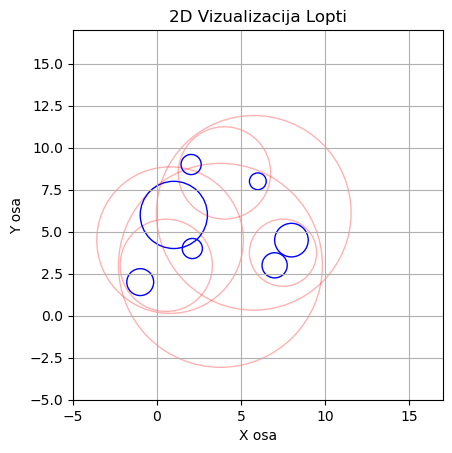

In [17]:
def plot_ball(ax, ball, color='b', alpha=1.0):
    """ Pomoćna funkcija za crtanje kruga. """
    circle = plt.Circle(ball.coordinates, ball.radius, color=color, fill=False, alpha=alpha)
    ax.add_artist(circle)

def plot_tree(node, ax, level=0, max_level=10):
    """ Rekurzivno prolazi kroz BallTree i crta sve lopte. """
    if node is None or level > max_level:
        return
    plot_ball(ax, node.ball, color='r' if node.left or node.right else 'b', alpha=0.3 if node.left or node.right else 1.0)
    plot_tree(node.left, ax, level+1, max_level)
    plot_tree(node.right, ax, level+1, max_level)

# Kreiranje grafika
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')

# Dodavanje lopti iz BallTree strukture
plot_tree(tree.root, ax)

# Podesavanje osa
ax.set_xlim(-5, 17)
ax.set_ylim(-5, 17)

# Prikazivanje grafika
plt.grid(True)
plt.xlabel('X osa')
plt.ylabel('Y osa')
plt.title('2D Vizualizacija Lopti')

plt.savefig('results/online1.png')

plt.show()

In [18]:
np.random.seed(42)
balls2= []
for _ in range(20):
    x = np.random.random() * 30
    y = np.random.random() * 30
    r = 1
    ball = Ball([x, y], r)
    balls2.append(ball)

In [19]:
nodes = []
for b in balls2:
    node = BallTreeNode(True)
    node.set_ball(b)
    nodes.append(node)
tree = BallTree()
for node in nodes:
  best_sibiling = tree.best_sibling(node)
  tree.ins_at_node(node, best_sibiling)

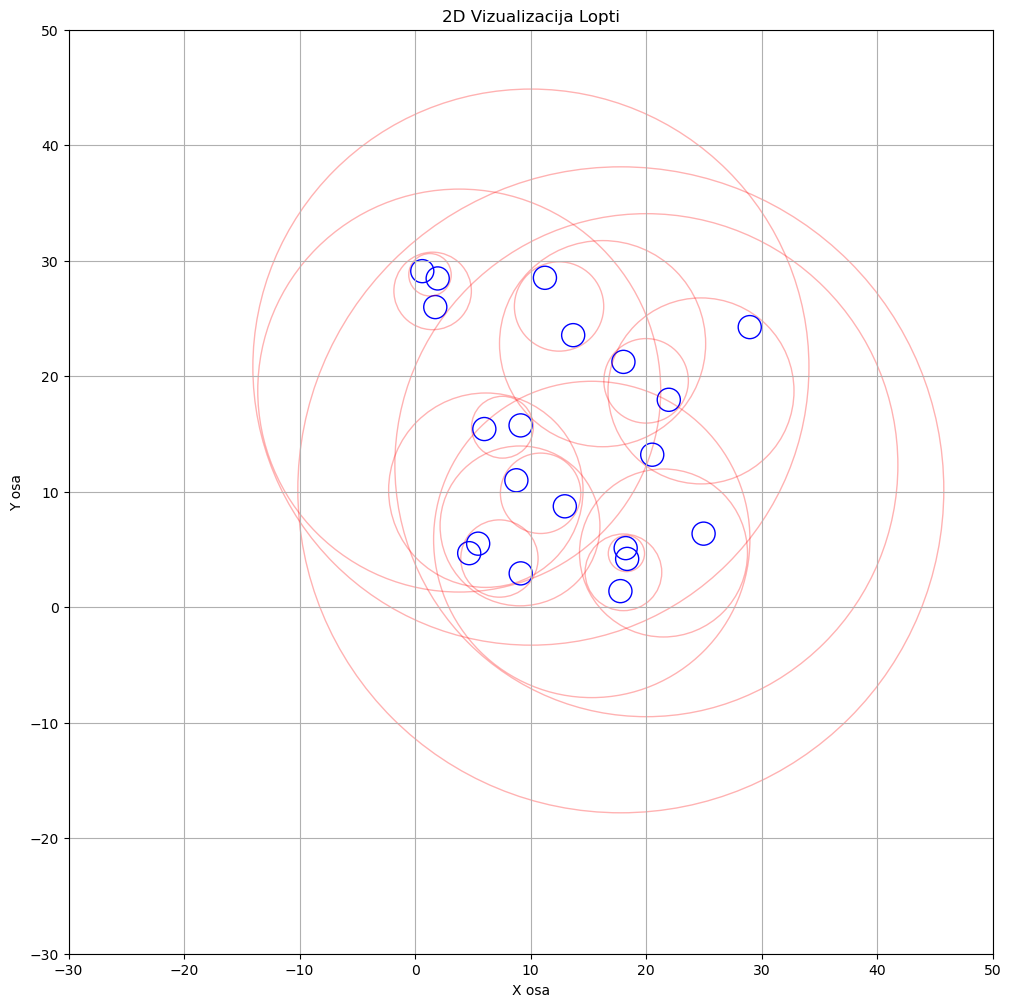

In [20]:
# Kreiranje grafika
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal', 'box')

# Dodavanje lopti iz BallTree strukture
plot_tree(tree.root, ax)

# Podesavanje osa
ax.set_xlim(-30, 50)
ax.set_ylim(-30, 50)

# Prikazivanje grafika
plt.grid(True)
plt.xlabel('X osa')
plt.ylabel('Y osa')
plt.title('2D Vizualizacija Lopti')
plt.savefig('onlineRes.png')

plt.show()

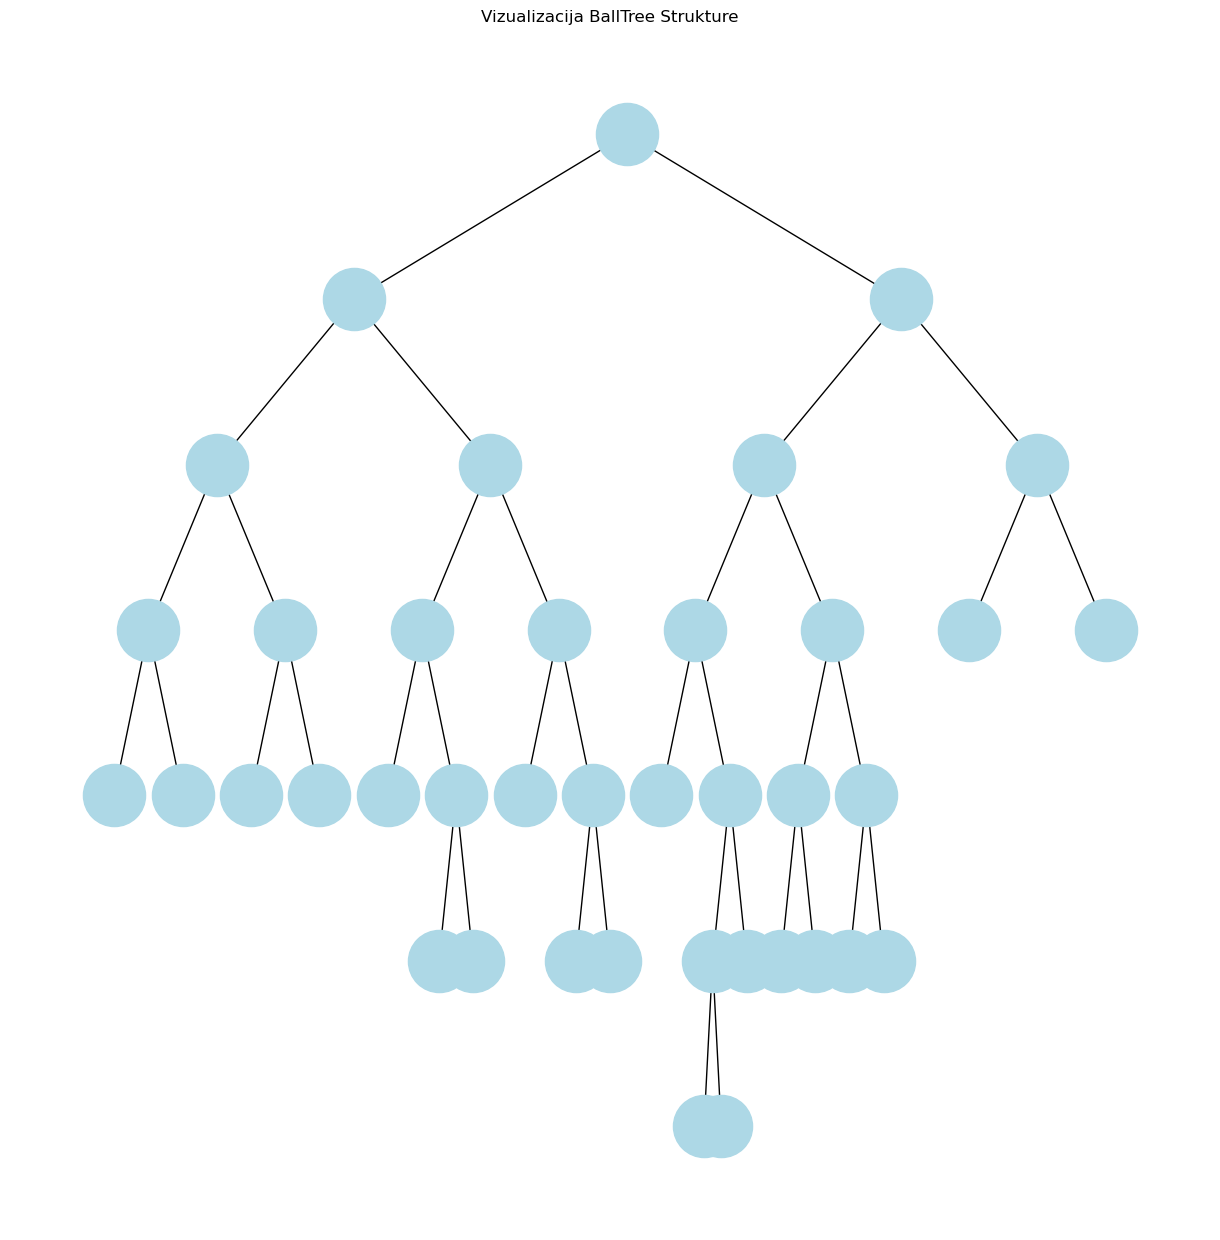

In [21]:
# Kreiranje grafa, pozicije i labele iz BallTree strukture
graph, pos, labels = plot_ball_tree(tree.root)

# Crtanje grafa
plt.figure(figsize=(12, 12))
nx.draw(graph, pos, node_size=2000, node_color='lightblue', font_size=8, font_weight='bold')
plt.title('Vizualizacija BallTree Strukture')
plt.savefig('results/online_graph2.png')
plt.show()